In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from task_decomposition.analysis.comparisons import (get_subtask_similarity,
                                                     get_IOU,
                                                     get_semantic_distance,
                                                     extract_subtask_from_groundtruth_file,
                                                     extract_subtask_from_LLM_output_file)
from task_decomposition.utils.random_subtask_decomposition import get_random_subtask_decomposition
from task_decomposition.paths import ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH, LLM_OUTPUT_PATH
from task_decomposition.constants import START_STEP_IDX, END_STEP_IDX, DESCRIPTION_IDX, ENVIRONMENT_NAMES

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-26 21:03:04.788709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

In [2]:
def _get_filepaths(env_name: str, llm_model: str, input_mode: str, kind:str) -> list:
    """
    Get the list of groundtruth or LLM output filepaths for a given environment
    """
    if kind == "groundtruth":
        files_path = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)
    elif kind == "llm_output":
        files_path = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)
    else:
        raise ValueError(f"Invalid kind {kind}. Must be either 'groundtruth' or 'llm_outputs'.")
    files = os.listdir(files_path)
    files.remove(".gitkeep") if ".gitkeep" in files else None
    files.remove(".DS_Store") if ".DS_Store" in files else None
    files = [os.path.join(files_path, file) for file in files]
    files = sorted(files)
    return files

### Trajectory Visualization Functions

In [3]:
def format_string(s: list) -> str:
    """
    Add a newline after every 3 words in the list
    """
    N_WORDS_PER_LINE = 3
    x = s.split(" ")
    s_format = []
    for i in range(len(x)):
        s_format.append(x[i])
        s_format.append("\n") if i % N_WORDS_PER_LINE == 0 else None
    return " ".join(s_format)

# Redefine the add_intervals_with_colors function to position the text at the edges
def add_intervals_with_colors(intervals, row, color_map, ax, angle):
    for idx, (start, end, description) in enumerate(intervals):
        color = color_map[0]
        rect_width = end - start if end - start > 0 else 1
        rect = mpatches.Rectangle(
            (start, row), rect_width, 0.8, edgecolor="black", facecolor=color
        )
        ax.add_patch(rect)

        # Position the text at the top and bottom edges of the bars
        if row == 1:  # For the top bar, start the text at the top edge
            text_y = row + 0.8
            va = "bottom"
        else:  # For the bottom bar, start the text at the bottom edge
            text_y = row
            va = "top"

        # Place the text at a 45 degree angle for actual and -45 for predicted
        ax.text(
            (start+end) / 2,
            text_y,
            format_string(description),
            ha="left",
            va=va,
            fontsize="large",
            color="black",
            rotation=angle,
            rotation_mode="anchor",
        )

def plot_trajectory_decomposition(actual, predicted, title, ax=None):
    color_map = ['green', 'blue', 'purple', 'orange', 'red', 'yellow', 'pink', 'brown', 'grey', 'cyan']

    # preprocess so that each subtask in predicted matches the maximum semantic score in actual
    # predicted_color_map = []
    # for p in predicted:
    #     max_score = -1
    #     max_idx = 0
    #     for idx, a in enumerate(actual):
    #         score = semantic_distance(a[2], p[2])
    #         if score >= max_score:
    #             max_score = score
    #             max_idx = idx
    #     predicted_color_map.append(color_map[max_idx])

    # Add actual intervals with color map and angle the text at 45 degrees
    add_intervals_with_colors(actual, 1, color_map, ax, angle=35)

    # Add predicted intervals with color map and angle the text at -45 degrees
    add_intervals_with_colors(predicted, 0, color_map, ax, angle=-35)

    # Set the limits, labels, and title
    ax.set_xlim(-2, max(actual[-1][END_STEP_IDX], predicted[-1][END_STEP_IDX])+5)
    ax.set_ylim(-7, 12)
    ax.set_yticks([0.4, 1.4])
    ax.set_yticklabels(["Predicted", "Ground Truth"], fontsize=12)
    ax.set_xlabel("Step Number")
    ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

### Visualize Individual Trajectories

Ground Truth Subtasks: [(0, 11, 'Move to cube'), (12, 13, 'Grasp Cube'), (14, 27, 'Lift Cube')]
LLM Subtasks: [(0, 9, 'robot arm moving towards the cube'), (10, 11, 'robot arm positioning to grip the cube'), (12, 13, 'gripper closing to grip the cube'), (14, 27, 'robot arm lifting the cube')]
Similarity between GT and LLM: {'temporal': 0.8701298701298702, 'semantic': 0.8015441766807012, 'total': 0.8358370234052857}


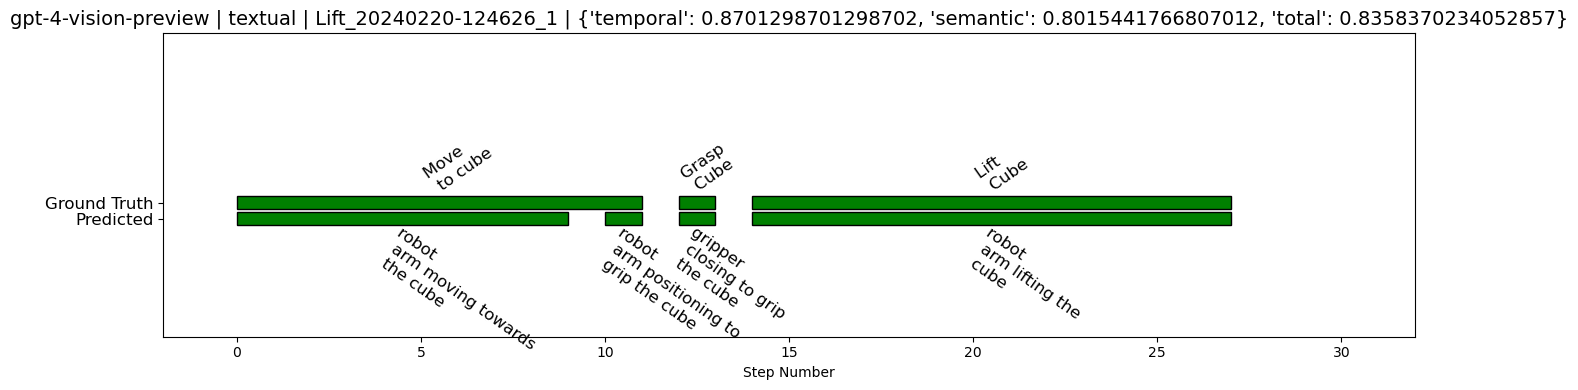

Random Decomposition: [(0, 17, 'Open a door'), (18, 22, 'Set a table'), (23, 26, 'Close a door'), (27, 27, 'Place object on a shelf')]
Similarity between GT and Random: {'temporal': 0.38529770882712056, 'semantic': 0.6372326612472534, 'total': 0.511265185037187}


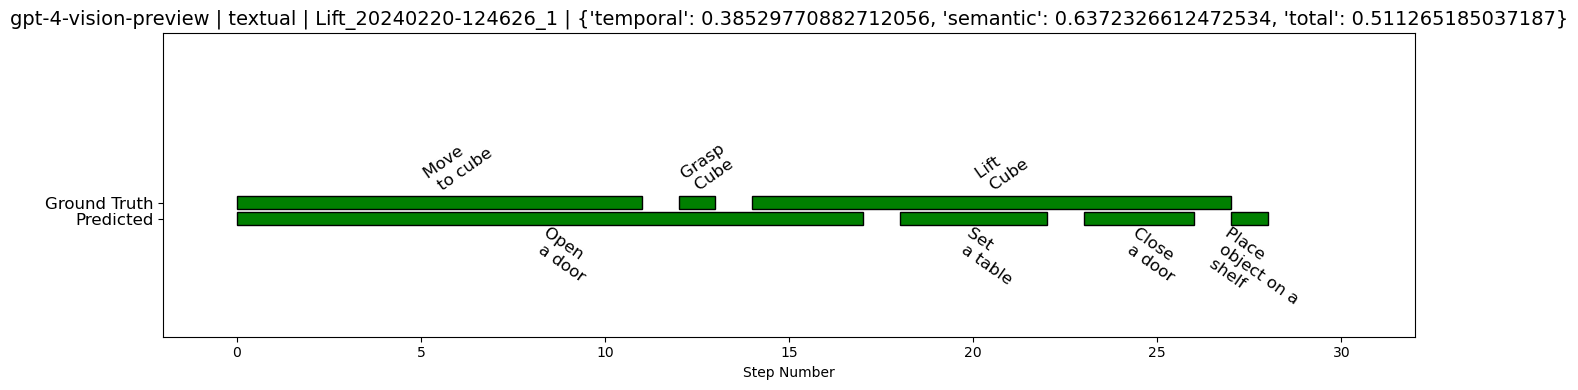

In [4]:
## visualize individual trajectory decompositions
# Example 1
# llm_model = "gpt-4-vision-pro"
# input_mode = "textual"
# env_name = "NutAssemblySquare"
# runid = "NutAssemblySquare_20240225-160456_0"

# Example 2
llm_model = "gpt-4-vision-preview"
input_mode = "textual"
env_name = "Lift"
runid = "Lift_20240220-124626_1"

# Example 3
# llm_model = "video-llava"
# input_mode = "video"
# env_name = "Stack"
# runid = "Stack_20240220-131112_39"


## Extract the groundtruth and LLM output files
gt_file = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)+f"/{runid}_gt.txt"
llm_file = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)+f"/{runid}.json" 

gt_subtasks = extract_subtask_from_groundtruth_file(filepath=gt_file)
llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file,
                                                    llm_model=llm_model)

print(f"Ground Truth Subtasks: {gt_subtasks}")
print(f"LLM Subtasks: {llm_subtasks}")

similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
print(f"Similarity between GT and LLM: {similarity}")

# # create new figure
fig, ax = plt.subplots(figsize=(14, 4))
title = f"{env_name} Environment, Total{similarity['total']:.2f}, Temporal: {similarity['temporal']:.2f}, Semantic Similarity: {similarity['semantic']:.2f}"
plot_trajectory_decomposition(actual=gt_subtasks,
                              predicted=llm_subtasks, 
                              title=f"{llm_model} | {input_mode} | {runid} | {similarity}", 
                              ax=ax)

random_subtask_decomposition = get_random_subtask_decomposition(gt_subtasks[-1][END_STEP_IDX])
print(f"Random Decomposition: {random_subtask_decomposition}")
similarity = get_subtask_similarity(gt_subtasks, random_subtask_decomposition)
print(f"Similarity between GT and Random: {similarity}")
fig, ax = plt.subplots(figsize=(14, 4))
title = f"{env_name} Environment, Total{similarity['total']:.2f}, Temporal: {similarity['temporal']:.2f}, Semantic Similarity: {similarity['semantic']:.2f}"
plot_trajectory_decomposition(actual=gt_subtasks,
                              predicted=random_subtask_decomposition, 
                              title=f"{llm_model} | {input_mode} | {runid} | {similarity}", 
                              ax=ax)

### Compute Similarity for one Trajectory

In [ ]:
runid = "NutAssemblySquare_20240225-160809_17"
# runid = "Stack_20240220-130911_22"
llm_model = "gpt-4-vision-preview"
input_mode = "textual"
env_name = "NutAssemblySquare"
gt_file = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)+f"/{runid}_gt.txt"
llm_file = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)+f"/{runid}.json"
gt_subtasks = extract_subtask_from_groundtruth_file(gt_file)
llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file, 
                                                    llm_model=llm_model)
print(f"Ground Truth Subtasks: {gt_subtasks}")
print(f"LLM Subtasks: {llm_subtasks}")
similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
print(similarity)

### Compute Similarity Metrics in batch by ENV_NAME, INPUT_MODE, LLM_MODEL

In [5]:
def compute_batch_similarity(env_name: str,
                             llm_model: str,
                             input_mode: str,
                             SAVE_OUTPUT: bool = True,
                             verbose: bool = True) -> None:
    """
    Compute the similarity between groundtruth and gpt output files for a given environment.
    """
    gt_files = _get_filepaths(env_name=env_name, 
                                llm_model=llm_model, 
                                input_mode=input_mode, 
                                kind="groundtruth")

    llm_files = _get_filepaths(env_name=env_name, 
                                llm_model=llm_model, 
                                input_mode=input_mode, 
                                kind="llm_output")

    assert len(gt_files) == len(llm_files), f"The number of groundtruth files {len(gt_files)} and LLM output files {len(llm_files)} are not the same."

    n_runs = len(gt_files)
    output = {"temporal":np.full(n_runs, np.nan), 
              "semantic":np.full(n_runs, np.nan), 
              "total":np.full(n_runs, np.nan)}

    for idx, (gt_file, llm_file) in enumerate(zip(gt_files, llm_files)):
        # make sure we are comparing the same run
        gt_runid = gt_file.split('/')[-1].split('_gt')[0]
        llm_runid = llm_file.split('/')[-1].split('.json')[0]
        assert gt_runid==llm_runid, f"The groundtruth file {gt_file} and llm output file {llm_file} are not from the same run."

        # extract subtasks from groundtruth and gpt output files
        gt_subtasks = extract_subtask_from_groundtruth_file(gt_file)
        llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file, 
                                                            llm_model=llm_model)

        if llm_subtasks == []:    # error with processing the file
            print(f"LLM subtask for {llm_runid} is empty")
            continue

        # compare the subtasks
        try:
            similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
        except Exception as e:
            print(f"Error with {llm_runid}: {e}")
            continue
        output['temporal'][idx]=similarity["temporal"]
        output['semantic'][idx]=similarity["semantic"]
        output['total'][idx]=similarity["total"]
        if verbose:
            print(f"Similarity between {gt_runid} and {llm_runid} is {similarity['total']:.2f}")

    # Clean the output in case nans are present
    output['temporal'] = output['temporal'][~np.isnan(output['temporal'])]
    output['semantic'] = output['semantic'][~np.isnan(output['semantic'])]
    output['total'] = output['total'][~np.isnan(output['total'])]

    if SAVE_OUTPUT:
        np.savez(f"{LLM_OUTPUT_PATH(llm_model, input_mode, env_name)}_results.npz", **output)

    print(f"Number of runs: {n_runs}, Number of valid runs: {len(output['total'])}")
    print(f"Average Similarity: {np.mean(output['total']):.2f}, Average Temporal Similarity: {np.mean(output['temporal']):.2f}, Average Semantic Similarity: {np.mean(output['semantic']):.2f}")

env_names = ENVIRONMENT_NAMES
input_mode = "textual"
llm_model = "gpt-4-vision-preview"
for env_name in env_names:
    compute_batch_similarity(env_name=env_name,
                            input_mode=input_mode,
                            llm_model=llm_model,
                            SAVE_OUTPUT=True)


Similarity between Door_20240213-183948_0 and Door_20240213-183948_0 is 0.66
Similarity between Door_20240213-183957_1 and Door_20240213-183957_1 is 0.70
Similarity between Door_20240213-184004_2 and Door_20240213-184004_2 is 0.64
Similarity between Door_20240213-184012_3 and Door_20240213-184012_3 is 0.82
Similarity between Door_20240213-184020_4 and Door_20240213-184020_4 is 0.67
Similarity between Door_20240213-184028_5 and Door_20240213-184028_5 is 0.63
Similarity between Door_20240213-184036_6 and Door_20240213-184036_6 is 0.57
Similarity between Door_20240213-184043_7 and Door_20240213-184043_7 is 0.64
Similarity between Door_20240213-184051_8 and Door_20240213-184051_8 is 0.59
Similarity between Door_20240213-184058_9 and Door_20240213-184058_9 is 0.87
Similarity between Door_20240213-184106_10 and Door_20240213-184106_10 is 0.68
Similarity between Door_20240213-184114_11 and Door_20240213-184114_11 is 0.79
Similarity between Door_20240213-184121_12 and Door_20240213-184121_12 i

In [ ]:
# sns.histplot(data=[temporal, semantic, total], legend=True, kde=True, bins=25)
# env_name = "Door"
# query_type = "video"
# npresultspath = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}" 
# similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
N_BINS = 20
def make_histogram_grid(env_names: list, input_modes: list):
    """
    Create a grid of histograms for the similarity scores between groundtruth and gpt output files.
    Each histogram will show the distribution of the similarity scores for a given environment and query type.
    """
    n_rows = len(input_modes)
    n_cols = len(env_names)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5*n_rows))
    for i, env_name in enumerate(env_names):
        for j, input_mode in enumerate(input_modes):
            npresultspath = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)
            similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
            temporal = similarity['temporal']
            semantic = similarity['semantic']
            ax = axs[j, i] if n_rows > 1 else axs[i]
            sns.histplot(data=[temporal, semantic], legend=True, bins=N_BINS, ax=ax)
            ax.legend(["Temporal", "Semantic"], loc='upper left')
            ax.set_xlabel('Similarity')
            ax.set_ylabel('Frequency')
            ax.set_xlim(0, 1)
            input_mode = "Text and Video" if input_mode=="textvideo" else input_mode.capitalize()
            ax.set_title(f"{llm_model} {input_mode} | {env_name}, ")

llm_model = "gemini-pro"
envs = ["Lift", "Door", "Stack", "PickPlace"]
# input_modes = ["textvideo", "text", "video"]
input_modes = ["text"]
make_histogram_grid(envs, input_modes)


### Make the rows for the table (LLM_NAME, ENV_NAME, INPUT_MODE, SIMILARITY_METRIC, SIMILARITY_VALUE)

In [7]:
# Make the big table of all the similarity results
llm_model = "gpt-4-vision-preview"
# query_types = ["textvideo", "text" , "video"]
# env_names = ["Lift", "Door", "Stack", "PickPlace"]
env_names = ENVIRONMENT_NAMES
input_modes = ["textual"]
for input_mode in input_modes:
    print(f"{input_mode}: ")
    for env_name in env_names:
        npresultspath =  LLM_OUTPUT_PATH(llm_model, input_mode, env_name)
        similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
        total_mean, total_std = np.mean(similarity['total']), np.std(similarity['total'])
        print(f" {env_name}", end="")
        temporal_mean, temporal_std = np.mean(similarity['temporal']), np.std(similarity['temporal'])
        semantic_mean, semantic_std = np.mean(similarity['semantic']), np.std(similarity['semantic'])
        print(f"\t\tTemporal: {temporal_mean:.2f} +/- {temporal_std:.2f}, Semantic: {semantic_mean:.2f} +/- {semantic_std:.2f}")
    print("______________________________________________________________________")

textual: 
 Door		Temporal: 0.71 +/- 0.13, Semantic: 0.68 +/- 0.07
 Lift		Temporal: 0.72 +/- 0.13, Semantic: 0.83 +/- 0.05
 NutAssemblySquare		Temporal: 0.23 +/- 0.27, Semantic: 0.67 +/- 0.06
 PickPlace		Temporal: 0.70 +/- 0.17, Semantic: 0.71 +/- 0.04
 Stack		Temporal: 0.67 +/- 0.11, Semantic: 0.64 +/- 0.10
______________________________________________________________________


### Compute Random Baselines for Each Environment

In [6]:
for env_name in ENVIRONMENT_NAMES:
    gt_files = _get_filepaths(env_name=env_name, 
                            llm_model=None, 
                            input_mode=None, 
                            kind="groundtruth")
    print(f"Env: {env_name}")
    n_runs = len(gt_files)
    output = {"temporal": np.full(n_runs, np.nan), 
              "semantic": np.full(n_runs, np.nan), 
              "total": np.full(n_runs, np.nan)}
    for idx, gt_file in enumerate(gt_files):
        gt_subtask_decomposition = extract_subtask_from_groundtruth_file(gt_file)
        N = gt_subtask_decomposition[-1][END_STEP_IDX]
        random_subtask_decomposition = get_random_subtask_decomposition(N)
        similarity = get_subtask_similarity(gt_subtask_decomposition, 
                                            random_subtask_decomposition)
        temporal = similarity['temporal']
        semantic = similarity['semantic']
        total = similarity['total']
        output['temporal'][idx] = temporal
        output['semantic'][idx] = semantic
        output['total'][idx] = total
        # print(f" Temporal: {temporal:.2f}, Semantic: {semantic:.2f}")

    print(f"Average Temporal: {np.mean(output['temporal']):.2f}, Average Semantic: {np.mean(output['semantic']):.2f}, Average Total: {np.mean(output['total']):.2f}")

Env: Door
Average Temporal: 0.37, Average Semantic: 0.60, Average Total: 0.49
Env: Lift
Average Temporal: 0.46, Average Semantic: 0.61, Average Total: 0.54
Env: NutAssemblySquare
Average Temporal: 0.46, Average Semantic: 0.55, Average Total: 0.51
Env: PickPlace
Average Temporal: 0.36, Average Semantic: 0.60, Average Total: 0.48
Env: Stack
Average Temporal: 0.30, Average Semantic: 0.59, Average Total: 0.45
